In [39]:
!pip install segmentation_models_pytorch                                          

In [40]:
import albumentations as A  

In [41]:
import gc
import os
import cv2  
import zipfile   
import rasterio
import numpy as np 
import math  
import pandas as pd 
from PIL import Image
import tifffile as tiff
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from rasterio.windows import Window
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader 
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import pytorch_lightning as pl 
import segmentation_models_pytorch as smp
from torch.cuda.amp import autocast, GradScaler
from torchvision import models
import torchvision
from torch.utils.checkpoint import checkpoint_sequential
from torch.utils.checkpoint import checkpoint
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

In [42]:
class cfg:
    epoch = 15
    train_batch_size = 16
    val_batch_size = 16 
    num_workers = os.cpu_count()    
    pin_memory = True 
    lr = 8e-5
    use_dataset = 0
    size = (384,384)
    loss_func = 'bce'
    device = 'cuda'

In [43]:
TRAIN_PATH = '../input/hubmap-organ-segmentation/train_images/'  
train_df = pd.read_csv('../input/hubmap-organ-segmentation/train.csv')

In [44]:
def mask2rle(img): # encoder
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape): # decoder 
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [45]:
def rescale(img, mask, size=cfg.size): 
    scaled_img = cv2.resize(img, size)
    scaled_mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    return scaled_img, scaled_mask

In [46]:
skf = StratifiedKFold(n_splits=5)

In [47]:
def to_bins(age):
    age_ = ''
    if(age <= 20.0):
        age_ = '0'
    elif(age <= 40.0):
        age_ = '1'
    elif(age <= 50.0):
        age_ = '2'
    elif(age <= 60.0):
        age_ = '3'
    else:
        age_ = '4'
    return age_

In [48]:
c_sum = []
for index, row in train_df.iterrows():
    c_sum.append(row['organ'] + to_bins(row['age']) + row['sex'])

In [49]:
train_df['c_sum'] = c_sum
fold_ = [0]*train_df.shape[0]

In [50]:
for k,(train_index, test_index) in enumerate(skf.split(train_df['id'], train_df['c_sum'])):
    for i in test_index:
        fold_[i] = k

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [51]:
train_df['fold'] = fold_

In [52]:
transform = A.Compose(
    [
        A.Resize(cfg.size[0],cfg.size[1]),
        A.Normalize(),
        ToTensorV2()
    ]
)

In [53]:
class HuBMAPDataset(Dataset):
    def __init__(self,df,transform):
        self.ids = df['id'].values  
        self.rle = df['rle'].values
        self.width = df['img_width'].values
        self.height = df['img_height'].values
        self.transform = transform 
    def __len__(self):  
        return len(self.ids)
    def __getitem__(self,idx):
        img  = tiff.imread(TRAIN_PATH + str(self.ids[idx]) +'.tiff')   
        mask = rle2mask(self.rle[idx], (self.height[idx],self.width[idx]))
        transformed = self.transform(image=img, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"] 
        image = torch.tensor(image)
        mask = torch.tensor(mask)
        #image = torch.permute(image,(2,0,1))
        return image,mask 

torch.Size([3, 384, 384])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


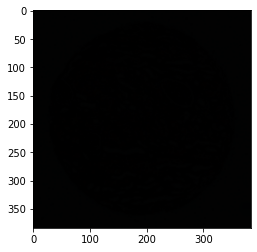

In [54]:
dataset = HuBMAPDataset(train_df,transform)  
image,mask = dataset[5]
print(image.shape)
plt.imshow(torch.permute(image,(1,2,0)).int())  

In [55]:
def stats(l):  
    return torch.tensor(l).float().mean(),torch.tensor(l).float().std()

In [56]:
def Dice_metric(preds,labels): 
    t1 = preds * labels
    t1 = 2 * torch.sum(t1,(1,2))
    t2 = preds + labels 
    t2 = torch.sum(t2,(1,2))
    t = t1 / (t2 + 1e-7)
    return t.mean()

In [57]:
def Dice_loss(preds,labels):
    return 1 - Dice_metric(preds,labels) 

In [58]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()
        self.diceloss = smp.losses.DiceLoss(mode='binary')
        self.binloss = smp.losses.SoftBCEWithLogitsLoss(reduction = 'mean' , smooth_factor = 0.1)

    def forward(self, output, mask):
        dice = self.diceloss(output,mask)
        bce = self.binloss(output , mask)
        loss = dice * 0.7 + bce * 0.3
        return loss

In [59]:
def train_model(model,dataloader,optimizer,scheduler = None):
    avgloss = 0.0
    s = nn.Sigmoid()
    scaler = GradScaler()
    model.train()
    loss_func = smp.losses.SoftBCEWithLogitsLoss(reduction = 'mean' , smooth_factor = 0.1)
    for image,mask in tqdm(dataloader):  
        optimizer.zero_grad()
        image = image.to(device = cfg.device)
        mask = mask.to(device = cfg.device)
        with autocast(enabled = True):
            output = model(image)
            mask = mask.float() 
            output = s(output)
            #dice_loss = Dice_loss(output, mask)
            dice_loss = loss_func(output.squeeze(),mask)
        avgloss += dice_loss
        scaler.scale(dice_loss).backward()  
        scaler.unscale_(optimizer)     
        torch.nn.utils.clip_grad_norm_(model.parameters(),1)
        optimizer.step()
        scaler.step(optimizer)  
        scaler.update()
        if(scheduler is not None):
            scheduler.step()
        avgloss += dice_loss
    return avgloss/len(dataloader)

In [60]:
def eval_model(model,dataloader):
    avgloss = 0.0
    avgmetric = 0.0 
    s = nn.Sigmoid()  
    model.eval()
    for image,mask in tqdm(dataloader):
        with torch.no_grad():
            image = image.to(device = cfg.device)
            mask = mask.to(device = cfg.device)
            output = model(image)
            mask = mask.float()  
            output = output.detach()
            mask = mask.detach()    
            output = s(output)
            output = output.round()
            dice = Dice_metric(output, mask)
            avgmetric += dice
            avgloss += (1 - dice)
    loss = avgloss/len(dataloader)
    metric = avgmetric/len(dataloader) 
    return loss,metric 

In [61]:
# nfold = 1   
# cv_res = []

# metric_train_plot = []
# metric_test_plot = []
# epoch_plot = []

# for k in range(nfold): 
#     train = train_df[train_df['fold'] != k] 
#     test = train_df[train_df['fold'] == k]     
#     model = smp.Unet(    
#         encoder_name="resnet152",        
#         encoder_weights="imagenet",       
#         in_channels=3,                        
#         classes=1  
#     )     
#     model = model.to(device = cfg.device)
#     optimizer = torch.optim.AdamW(filter(lambda x: x.requires_grad == True, model.parameters()),lr = cfg.lr)
#     train_dataset = HuBMAPDataset(train,transform)
#     test_dataset = HuBMAPDataset(test,transform)
#     train_loader = DataLoader(train_dataset,batch_size = cfg.train_batch_size,num_workers = os.cpu_count(),
#                               pin_memory = cfg.pin_memory,shuffle=True)
#     test_loader = DataLoader(test_dataset,batch_size = cfg.val_batch_size,num_workers = os.cpu_count(),
#                              pin_memory = cfg.pin_memory,shuffle=False)
#     #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max = len(train_loader))
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
#                                               max_lr=1e-3, epochs=cfg.epoch, steps_per_epoch=len(train_loader))
#     '''
#         Early stopping: saving the best model in every fold
#     ''' 
#     metric_train_fold_plot = []
#     metric_test_fold_plot = []
#     epoch_fold_plot = []
    
#     current_loss = 1.0
#     for epoch in range(cfg.epoch):
#         break
#         loss = train_model(model,train_loader,optimizer,scheduler = scheduler)
#         torch.cuda.empty_cache()                         
#         gc.collect()
#         loss_test,metric_test = eval_model(model,test_loader) 
#         loss_train,metric_train = eval_model(model,train_loader)
#         print('test loss: ',loss_test.item(),' test metric: ',metric_test.item())
#         print('train loss: ',loss_train.item(),' train metric: ',metric_train.item())
#         metric_train_fold_plot.append(metric_train.item())
#         metric_test_fold_plot.append(metric_test.item())
#         epoch_fold_plot.append(epoch)
        
#         if(loss_test.item() < current_loss):
#             torch.save({            
#                 'epoch': epoch,         
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'scheduler': scheduler.state_dict(),
#                 'loss': loss_test, 
#             }, './checkpoint' + str(k) + '.pth')
#             print('Saving model with loss: ',loss_test.item())
#             current_loss = loss_test.item()                                                                                 

In [62]:
model = smp.Unet(    
        encoder_name="resnet152",        
        encoder_weights="imagenet",       
        in_channels=3,                        
        classes=1  
    )    

In [63]:
model_path = '/kaggle/input/models1/'
checkpoint = torch.load(model_path + 'pretrain_models.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device = 'cuda')

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

torch.Size([3, 384, 384])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


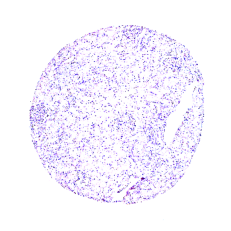

In [64]:
example_dataset = HuBMAPDataset(train_df,transform) 
image,mask = example_dataset[16]  
print(image.shape)
plt.imshow(torch.permute(image,(1,2,0)))
plt. axis('off')
plt.savefig('test_1.png')

torch.Size([384, 384])
torch.Size([384, 384])


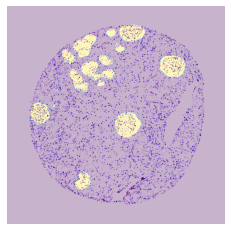

In [65]:
image = image.unsqueeze(dim = 0)

mask_ = model(image.to(device = 'cuda'))
s = nn.Sigmoid()
mask_ = s(mask_)
mask_ = mask_.detach().round().int().squeeze().cpu()

plt.imshow(torch.permute(image[0,:,:,:],(1,2,0)))
plt.imshow(mask_, alpha=0.3)
plt. axis('off')
plt.savefig('test_2.png')

print(mask_.shape)
print(mask_.squeeze().cpu().shape)

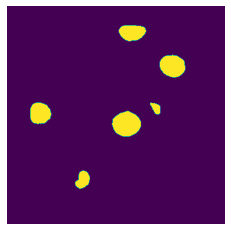

In [66]:
plt.imshow(mask)
plt. axis('off')
plt.savefig('test_label.png')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


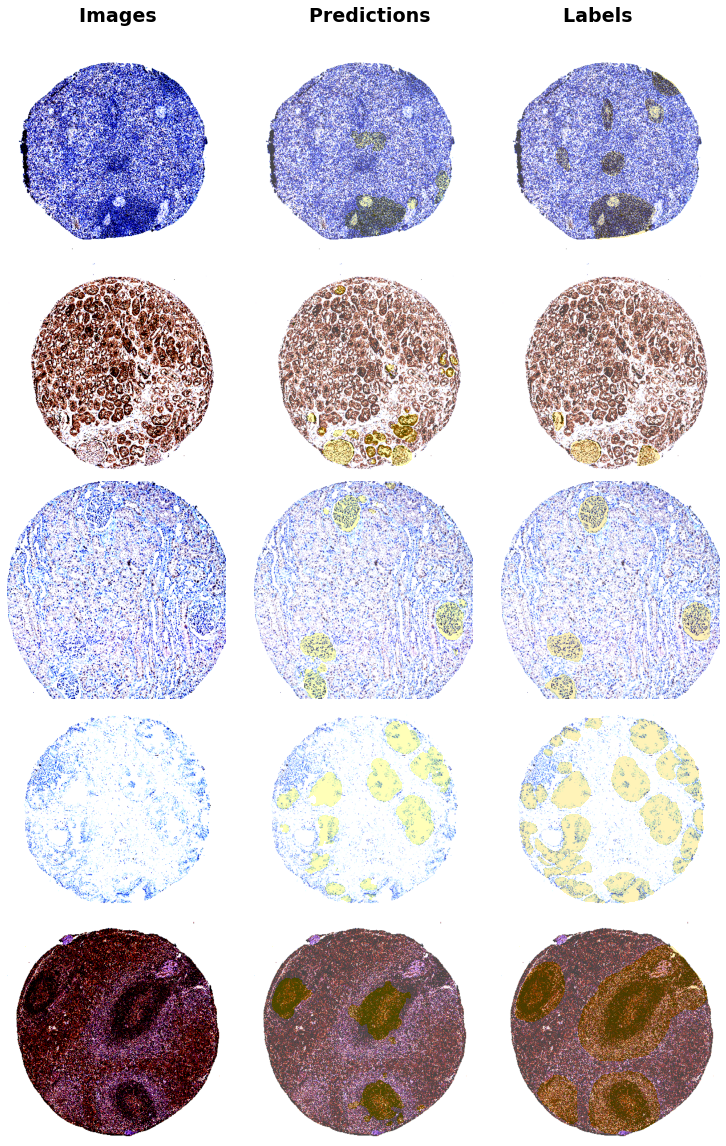

In [76]:
import matplotlib.colors
index = [0,1,7,84,151]
index = [12,74,85,235,24]

cols = ['Images','Predictions','Labels']

fig, ax = plt.subplots(5, 3, figsize=(10, 16))
fig.tight_layout(pad=-2.0)


# for a, col in zip(ax[0], cols):
#     a.set_title(col,fontweight="bold", size=19)

for i in range(5):
    image, label = example_dataset[index[i]] 
    ax[i][0].imshow(torch.permute(image,(1,2,0)))
    ax[i][1].imshow(torch.permute(image,(1,2,0)))
    ax[i][2].imshow(torch.permute(image,(1,2,0)))
    
    image = image.unsqueeze(dim = 0)
    mask_ = model(image.to(device = 'cuda'))
    s = nn.Sigmoid()
    mask_ = s(mask_)
    mask_ = mask_.detach().round().int().squeeze().cpu()
    
    ax[i][1].imshow(mask_, alpha=0.28, cmap = matplotlib.colors.ListedColormap(['white', 'yellow']))
    ax[i][2].imshow(label, alpha=0.28, cmap = matplotlib.colors.ListedColormap(['white', 'gold']))
    
    ax[i][0].axis('off')
    ax[i][1].axis('off')
    ax[i][2].axis('off')

fig.suptitle("Images                       Predictions                    Labels", fontweight="bold", size=19)
plt.subplots_adjust(top=0.95)
plt.savefig('examples.png')

## Test

In [77]:
TEST_PATH = '../input/hubmap-organ-segmentation/test_images/'  
test_df = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')

In [79]:
class HuBMAPTestDataset(Dataset):
    def __init__(self,df,transform):
        self.ids = df['id'].values  
        self.width = df['img_width'].values
        self.height = df['img_height'].values
        self.transform = transform 
    def __len__(self):  
        return len(self.ids)
    def __getitem__(self,idx):
        img  = tiff.imread(TEST_PATH + str(self.ids[idx]) +'.tiff')   
        mask = rle2mask(self.rle[idx], (self.height[idx],self.width[idx]))
        transformed = self.transform(image=img, mask=mask)
        image = transformed["image"]
        mask = transformed["mask"] 
        image = torch.tensor(image)
        mask = torch.tensor(mask)
        #image = torch.permute(image,(2,0,1))
        return image,mask 

In [80]:
test_dataset = HuBMAPTestDataset(test_df,transform)  
test_image,mask = dataset[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


In [71]:
transform_2 = A.Compose(
    [
        A.Resize(2023,2023)
    ]
)

In [81]:
test_image = test_image.unsqueeze(dim = 0)
mask_ = model(test_image.to(device = 'cuda'))
s = nn.Sigmoid()
mask_ = s(mask_)
mask_ = mask_.detach().round().int().to(device = 'cpu').numpy()[0,0,:,:]
print(mask_.shape)

(384, 384)


In [82]:
submission_rle = mask2rle(mask_)

d = {'id': ["10078"], 'rle': [submission_rle]}
submission = pd.DataFrame(data=d)
submission

,id,rle
0,10078,25184 3 25563 10 25944 14 26326 17 26708 20 27...


In [83]:
submission.to_csv("submission.csv")